In [2]:
# Analysis of global COVID-19 data

# Import relevant programs
import numpy as np 
import pandas as pd 
import seaborn as sns
import cycler

from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import image as image
from matplotlib import cbook as cbook
from matplotlib.colors import ListedColormap
from matplotlib.image import imread
from matplotlib.dates import DateFormatter

from mdutils.mdutils import MdUtils
from mdutils import Html

import datetime

#Theme
# from qbstyles import mpl_style
# import mplcyberpunk

In [3]:
# Dependencies
#-----------------


# Programs
# pip install mdutils # For markdown export


# Styling
# pip install SciencePlots # For scientific styling
# pip install qbstyles # (not actively used)
# pip install mplcyberpunk # (not actively used)


In [4]:
# References
#------------

# Dong E, Du H, Gardner L. An interactive web-based dashboard to track COVID-19 in real time. Lancet Inf Dis. 20(5):533-534. doi: 10.1016/S1473-3099(20)30120-1

# Garrett, J. garrettj403/SciencePlots (v1.0.6). October 2020. doi:10.5281/zenodo.4106650.

In [5]:
execute_start_time = datetime.datetime.now()
print("Jupyter notebook run started at: ")
print(str(execute_start_time))

Jupyter notebook run started at: 
2020-12-26 02:24:26.653690


In [6]:
#Load COVID Data

covid_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_data = covid_data.drop(columns=['Province/State', 'Lat', 'Long'])
covid_data.rename(columns = {'Country/Region': 'Country'}, inplace = True)
covid_data = covid_data.groupby('Country').agg('sum')


In [7]:
# Create a time series by transforming the covid.data 

covid_data = covid_data.T
datetime_index = pd.to_datetime(covid_data.index)
covid_data = covid_data.set_index(datetime_index)
covid_data.rename(columns = {'Korea, South': 'South Korea'}, inplace = True)

[jhu_days, jhu_countries] = covid_data.shape

#Last Updated

last_updated = covid_data.index[-1]
# format = "%A, %b %d, %Y at %I:%M:%S %p"
date_readable_format = "%A, %b %d, %Y at %I:%M:%S %p %Z"
date_machine_format = "%Y-%m-%d %I%M%S"
last_updated_readable = last_updated.strftime(date_readable_format)
last_updated_machine = last_updated.strftime(date_machine_format)



In [8]:
stablized_countries = covid_data.loc[:, ['Iran', 'Japan', 'South Korea']]


In [9]:
#Phase 1 countries

phase1 = covid_data.loc[:, ['Austria', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'US']]

# phase1.head(20)


In [10]:
#Cutoff for seeding cases

seed_cutoff = 100

In [11]:
#Truncate the COVID-19 cases based on the variable seed_cutoff, defined above

countries_100cuts = covid_data.where(covid_data > seed_cutoff, np.nan)

for col in countries_100cuts.columns:
    countries_100cuts[col] = sorted(countries_100cuts[col], key=pd.isnull)


countries_100cuts.dropna(axis = 0, how = 'all', inplace = True)
countries_100cuts.insert(0, 'Days', range(1, 1 + len(countries_100cuts)))
countries_100cuts.set_index(['Days'], inplace=True)

In [12]:
phase1_100cuts = countries_100cuts.loc[:, ['Austria', 'Belgium', 'Canada', 'France', 'Germany', 'Italy', 'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden', 'Switzerland', 'United Kingdom', 'US']]

In [13]:
#Calculate Doubling Times

doubling_window = 7 #days

doubling_time = ((doubling_window * np.log(2))) / (np.log(countries_100cuts.loc[7, :]) - np.log(countries_100cuts.loc[1, :]))
#Convert Pandas series to dataframe
doubling_time = pd.DataFrame(doubling_time)

#Add an index column
doubling_time.reset_index(level=0, inplace=True)

#Rename the columns
doubling_time.columns = ['Country', 'Days']

#Removing blank rows
doubling_time['Days'].replace('', np.nan, inplace=True)
doubling_time.dropna(subset=['Days'], inplace=True)

#Sort by ascending order of doubling time
doubling_time = doubling_time.sort_values(by='Days')

doubling_countries = doubling_time.Country.unique()

In [14]:
#Calculate Present Day Doubling Times

present_countries_100cuts = covid_data

present_countries_100cuts = present_countries_100cuts.reindex(index=present_countries_100cuts.index[::-1])
present_countries_100cuts.insert(0, 'Days', range(1, 1 + len(countries_100cuts)))
present_countries_100cuts.set_index(['Days'], inplace=True)

current_doubling_window = 7 #days


current_doubling_time = ((current_doubling_window * np.log(2))) / (np.log(present_countries_100cuts.loc[1, :]) - np.log(present_countries_100cuts.loc[current_doubling_window, :]))
#Convert Pandas series to dataframe
current_doubling_time = pd.DataFrame(current_doubling_time)

#Add an index column
current_doubling_time.reset_index(level=0, inplace=True)

#Rename the columns
current_doubling_time.columns = ['Country', 'Days']

#Removing blank rows
current_doubling_time['Days'].replace('', np.nan, inplace=True)
current_doubling_time.dropna(subset=['Days'], inplace=True)

#Sort by ascending order of doubling time
current_doubling_time = current_doubling_time.sort_values(by='Days')

current_doubling_countries = current_doubling_time.Country.unique()

current_doubling_US = current_doubling_time.loc[current_doubling_time['Country'] == 'US'].iloc[0, 1]
current_doubling_India = current_doubling_time.loc[current_doubling_time['Country'] == 'India'].iloc[0, 1]


In [15]:
#Formatting the following figures

axes_fontsize = 15
title_fontsize = 20
label_size = 10
fig_dpi = 150
fig_width = 8
fig_height = 5
twitter_alpha = .5

india_color = "#FF8F1C"
usa_color = "#041E42"

jhu_source = "Data source: JHU CSSE COVID-19 Data. https://github.com/CSSEGISandData/COVID-19"


with cbook.get_sample_data('Twitter/twitter_watermark_black.png') as file:
    twitter = image.imread(file)

# fig, ax1 = plt.subplots(figsize=(10, 7), dpi = fig_dpi)
# figXXX.figimage(twitter, 825, 40, zorder=3, alpha=.3)    

#Formatting
plt.style.use(['science','no-latex'])
# plt.style.use('pitayasmoothie-dark')


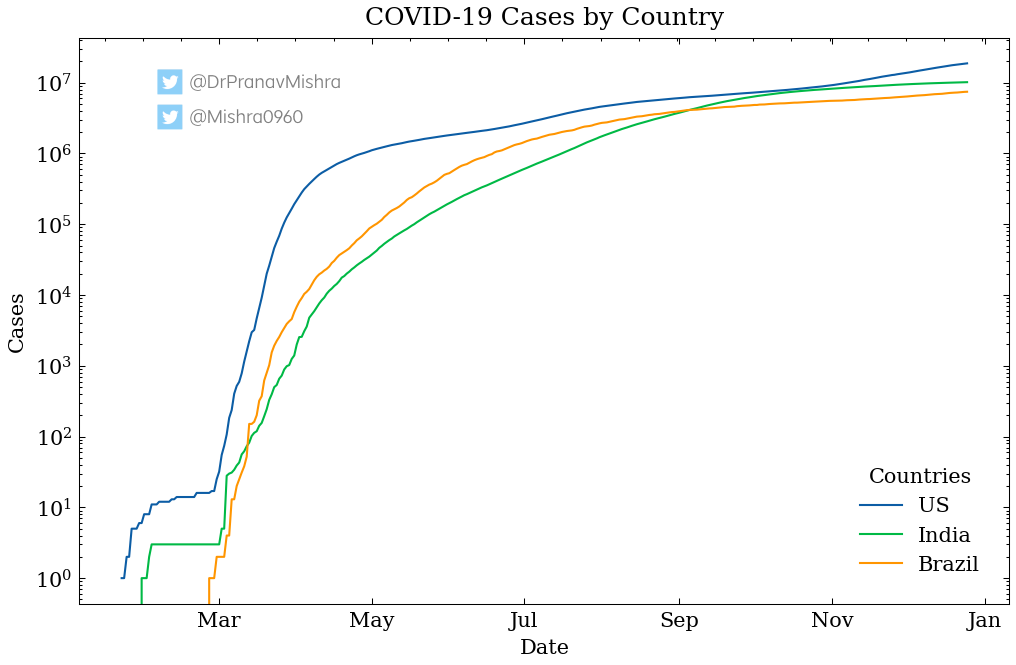

In [16]:
# Plot the data

#Initialize figure
fig1, ax1 = plt.subplots(figsize=(fig_width, fig_height), dpi = fig_dpi)
selected_countries = ['US', 'India', 'Brazil']
# selected_countries = phase1_100cuts.columns
plotting_columns = covid_data[selected_countries]


# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(datetime_index, plotting_columns)

#Formatting
plt.title('COVID-19 Cases by Country')

ax1.legend(selected_countries, bbox_to_anchor=(1, 0), loc="lower right", borderaxespad=1, ncol=1, title='Countries') #set to show selected_countries

ax1.set_xlabel("Date")
ax1.set_ylabel('Cases')
ax1.set_yscale('log')

formatter = DateFormatter("%b")
ax1.xaxis.set_major_formatter(formatter)
ax1.xaxis.set_tick_params(which='minor', bottom=False)

#JHU Source
# plt.text(500, 500, jhu_source, zorder=1, alpha=twitter_alpha, fontsize=6)

#Twitter Watermark
[twitter_width, b, c, twitter_height] = ax1.bbox.extents
twitter_width = (twitter_width*1).round(0)
twitter_height = (twitter_height*.8).round(0)
fig1.figimage(twitter, twitter_width, twitter_height, zorder=3, alpha=twitter_alpha) 

fig1.set_figheight(fig_height)
fig1.set_figwidth(fig_width)


fig1.show()
fig1.savefig('../Figures/COVID-19_Cases_in_Select_Countries.jpg', pad_inches=0.2, transparent=False) 

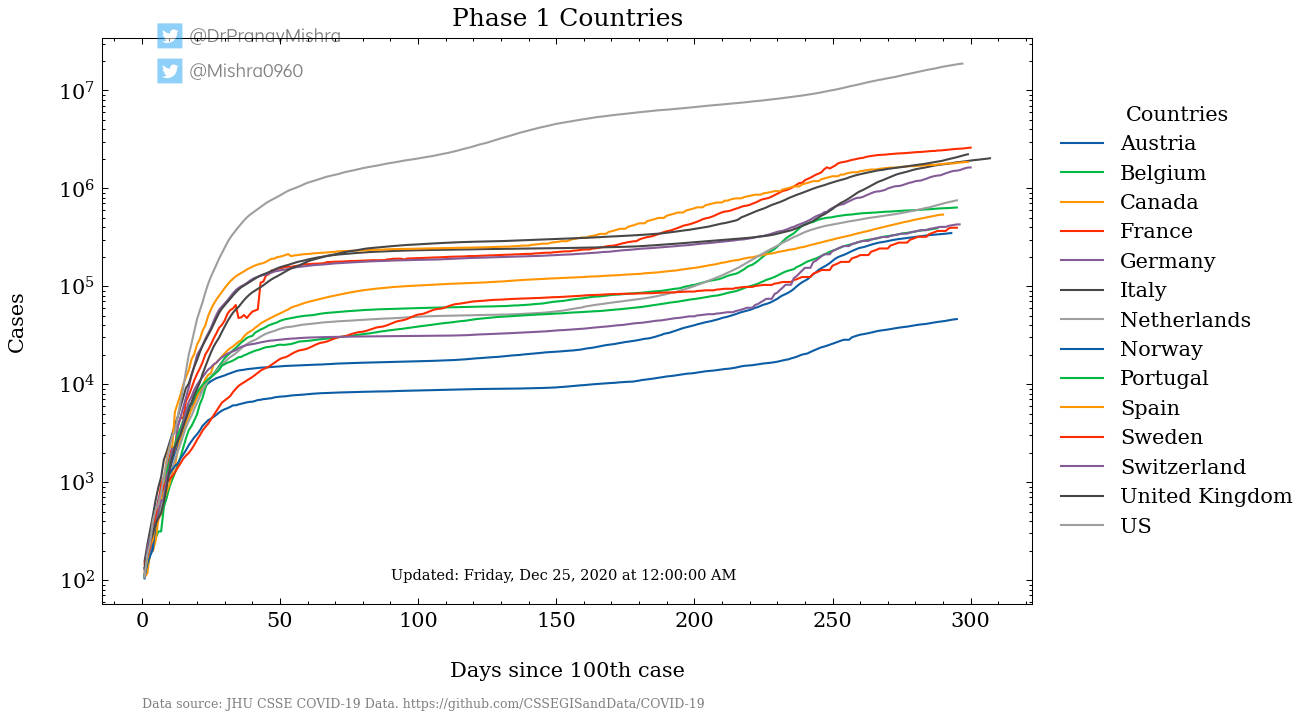

In [17]:
# Fig 2: Plotting Phase 1 Countries

#Initialize figure
fig2, ax1 = plt.subplots(figsize=(fig_width, fig_height), dpi = fig_dpi)

#which countries should be plotted 
# selected_countries = ['US', 'India', 'Brazil'] #these ones
selected_countries = phase1_100cuts.columns # all of them
plotting_columns = countries_100cuts[selected_countries]

ax1.plot(countries_100cuts.index, plotting_columns)


#Formatting

plt.title('Phase 1 Countries')

# ax1.legend(selected_countries, bbox_to_anchor=(0.5, 0), loc="lower center", borderaxespad=1, ncol=5, title='Countries', title_fontsize = 13) #set to show selected_countries

ax1.legend(selected_countries,bbox_to_anchor=(1, 0.5), loc="center left", borderaxespad=1,title='Countries', frameon=False)

ax1.set_xlabel("Days since 100th case")
ax1.xaxis.labelpad = 15
ax1.yaxis.labelpad = 15
ax1.set_ylabel('Cases')
ax1.set_yscale('log')

#JHU Source
plt.text(0, 5, jhu_source, zorder=1, alpha=twitter_alpha, fontsize=6)

#Twitter Watermark
[twitter_width, b, c, twitter_height] = ax1.bbox.extents
twitter_width = (twitter_width*1).round(0)
twitter_height = (twitter_height*.95).round(0)
fig2.figimage(twitter, twitter_width, twitter_height, zorder=3, alpha=twitter_alpha) 

#Last Updated
max_days = plotting_columns.dropna(how = 'all').index[-1] #Drop all empty rows, find the last index (day)
plt.text(max_days/2, 100, "Updated: " + last_updated_readable, horizontalalignment='center', fontsize=7)

fig2.show()
fig2.savefig('../Figures/Phase_1_Countries.jpg', bbox_inches="tight", pad_inches=0.3, transparent=False)

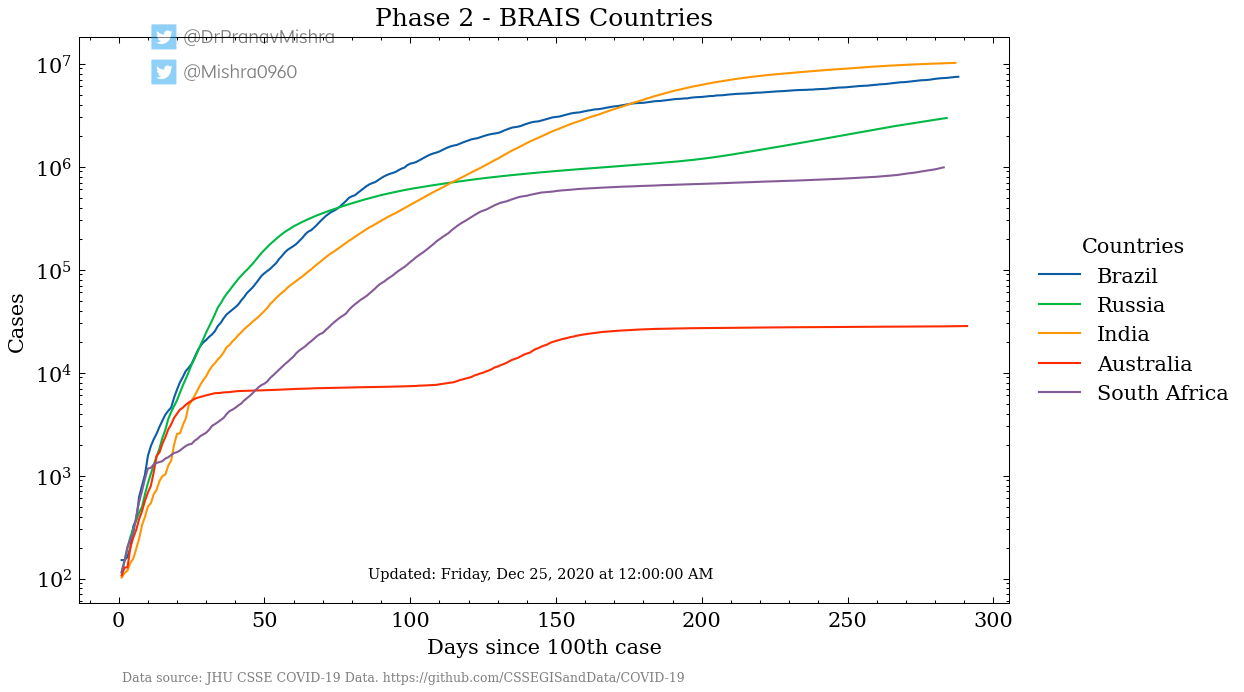

In [18]:
# Fig 3: Plotting BRIAS Nations

#Initialize figure
fig3, ax1 = plt.subplots(figsize=(fig_width, fig_height), dpi = fig_dpi)

#which countries should be plotted 
selected_countries = ['Brazil', 'Russia', 'India', 'Australia', 'South Africa'] #these ones
plotting_columns = countries_100cuts[selected_countries]


# ax1.scatter(plotting_columns.index, plotting_columns, label = selected_countries)
# ax1.plot(plotting_columns, label=selected_countries)

# plt.plot(plotting_columns.index, plotting_columns[selected_countries], label=selected_countries)

ax1.plot(countries_100cuts.index, plotting_columns)
# ax1.set(xlim=(0, 250), ylim=(1000000, 30000000))


#Formatting

plt.title('Phase 2 - BRAIS Countries')

ax1.legend(selected_countries,bbox_to_anchor=(1, 0.5), loc="center left", borderaxespad=1,title='Countries', frameon=False) #set to show selected_countries


ax1.set_xlabel("Days since 100th case")
ax1.set_ylabel('Cases')
ax1.set_yscale('log')

#JHU Source
plt.text(1, 10, jhu_source, zorder=1, alpha=twitter_alpha, fontsize=6)

#Twitter Watermark
[twitter_width, twitter_height] = fig3.get_size_inches()*fig3.dpi
twitter_width = (twitter_width*.12).round(0)
twitter_height = (twitter_height*.8).round(0)

fig3.figimage(twitter, twitter_width, twitter_height, zorder=4, alpha=twitter_alpha) 

#Last Updated
max_days = plotting_columns.dropna(how = 'all').index[-1] #Drop all empty rows, find the last index (day)
plt.text(max_days/2, 100, "Updated: " + last_updated_readable, horizontalalignment='center', fontsize=7)

#Save Figure


fig3.show()
fig3.savefig('../Figures/Phase_2_BRIAS_Countries.jpg' , bbox_inches="tight", pad_inches=0.3, transparent=False)

In [19]:
# #Minimum number of cases for a country to be considered

# seed_cutoff = 1000000


# #Truncate the COVID-19 cases based on the variable seed_cutoff, defined above

# countries_100cuts = covid_data.where(covid_data > seed_cutoff, np.nan)

# for col in countries_100cuts.columns:
#     countries_100cuts[col] = sorted(countries_100cuts[col], key=pd.isnull)


# countries_100cuts.dropna(axis = 0, how = 'all', inplace = True)
# countries_100cuts.insert(0, 'Days', range(1, 1 + len(countries_100cuts)))
# countries_100cuts.set_index(['Days'], inplace=True)


# #Calculate Doubling Times

# doubling_window = 7 #days

# doubling_time = (((doubling_window * np.log(2))) / (np.log(countries_100cuts.loc[7, :]) - np.log(countries_100cuts.loc[1, :]))).round(1)

# doubling_time

# #Convert Pandas series to dataframe
# doubling_time = pd.DataFrame(doubling_time)

# #Add an index column
# doubling_time.reset_index(level=0, inplace=True)

# #Rename the columns
# doubling_time.columns = ['Country', 'Days']

# #Removing blank rows
# doubling_time['Days'].replace('', np.nan, inplace=True)
# doubling_time.dropna(subset=['Days'], inplace=True)

# #Sort by ascending order of doubling time
# doubling_time = doubling_time.sort_values(by='Days')

# doubling_countries = doubling_time.Country.unique()
# doubling_time['Days'] = doubling_time['Days'].astype(str)

# # Fig 4: Plotting Doubling Countries 
# #-----------------------------------


# #Initialize figure
# fig4, ax1 = plt.subplots(figsize=(fig_width, fig_height), dpi = fig_dpi)

# #which countries should be plotted 

# selected_countries = doubling_countries
# plotting_columns = countries_100cuts[selected_countries]



# #Doubling Time 
# legend_doubling_time = doubling_time['Country'] + str(" = ") + doubling_time['Days']
# # doubling_time_string = doubling_time.to_string
# # legend_doubling_time = doubling_time_string.Country.str.cat(doubling_time_string.Days,sep=" ")
# # legend_doubling_time


# # ax1.plot(countries_100cuts.index, plotting_columns, color='grey')
# ax1.plot(countries_100cuts.index, plotting_columns)
# # ax1.plot(countries_100cuts.index, plotting_columns['US'], color=usa_color, linewidth=2)
# # ax1.plot(countries_100cuts.index, plotting_columns['India'], color=india_color, linewidth=2)

# plt.title('How countries cross the 1-million case landmark')

# ax1.legend(legend_doubling_time, bbox_to_anchor=(1, 0.5), loc="center left", borderaxespad=1,title='Doubling Time (Days)', frameon=False)


# #Labels
# max_days_india = plotting_columns['India'].index.get_loc(plotting_columns['India'].last_valid_index())
# max_days_us = plotting_columns['US'].index.get_loc(plotting_columns['US'].last_valid_index())

# plt.text((max_days_us + 5), plotting_columns['US'][max_days_us], 'US', horizontalalignment='left', fontsize=label_size, color=usa_color)

# plt.text((max_days_india + 5), plotting_columns['India'][max_days_india], 'India', horizontalalignment='left', fontsize=label_size, color=india_color)


# #JHU Source
# plt.text(1, 600000, jhu_source, zorder=1, alpha=twitter_alpha, fontsize=6)

# #Twitter Watermark
# [twitter_width, twitter_height] = fig4.get_size_inches()*fig4.dpi
# twitter_width = (twitter_width*.1).round(0)
# twitter_height = (twitter_height*.8).round(0)

# fig4.figimage(twitter, twitter_width, twitter_height, zorder=4, alpha=twitter_alpha) 


# ax1.set_xlabel("Days since 1 millionth case")
# ax1.set(xlim=(0, 275), ylim=(1000000, 30000000))

# ax1.set_ylabel('Cases')
# ax1.set_yscale('log')

# fig4.show()
# fig4.savefig('../Figures/Doubling_time_when_crossing_1M_cases.jpg', bbox_inches="tight", pad_inches=0.3, transparent=False)

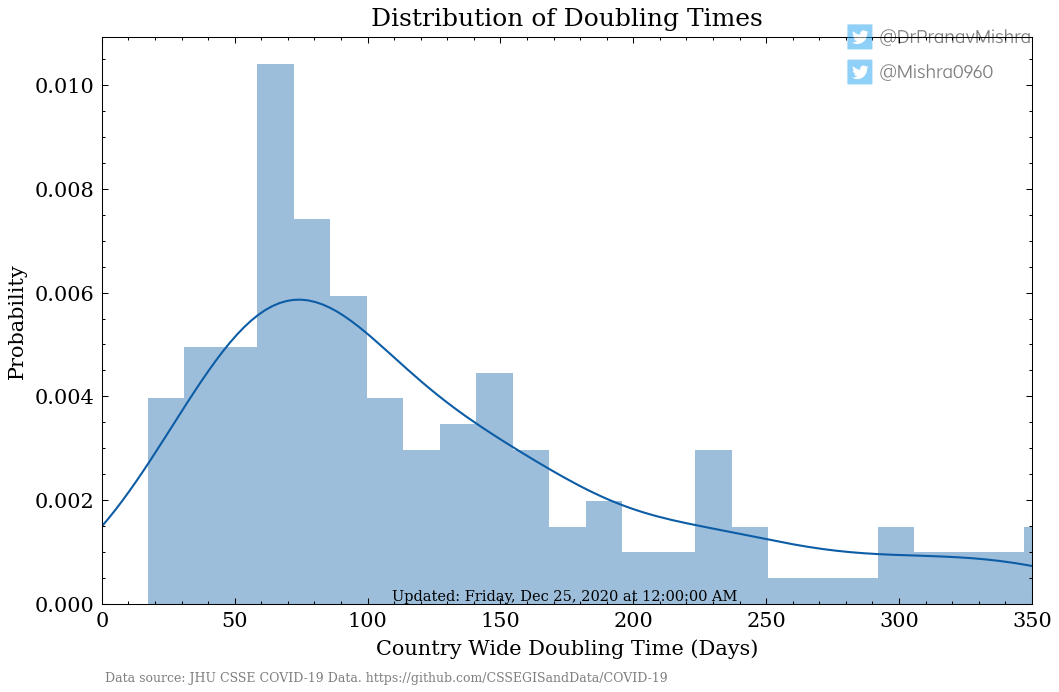

In [20]:
# Doubling Time Histogram
current_doubling_time_truncated = current_doubling_time.loc[current_doubling_time['Days'] < 365]

#Initialize figure
fig5, ax1 = plt.subplots(figsize=(fig_width, fig_height), dpi = fig_dpi)
x_max = 350
plt.xlim(0, x_max)
fig5 = sns.distplot(current_doubling_time_truncated['Days'], bins=25)

plt.title('Distribution of Doubling Times')
ax1.set_xlabel("Country Wide Doubling Time (Days)")
ax1.set_ylabel("Probability")

fig5 = fig5.get_figure()

#JHU Source
plt.text(1, -.0015, jhu_source, zorder=1, alpha=twitter_alpha, fontsize=6)

#Twitter Watermark
[twitter_width, twitter_height] = fig5.get_size_inches()*fig5.dpi
twitter_width = (twitter_width*.7).round(0)
twitter_height = (twitter_height*.8).round(0)

fig5.figimage(twitter, twitter_width, twitter_height, zorder=4, alpha=twitter_alpha) 


#Last Updated
plt.text(x_max/2, 0, "Updated: " + last_updated_readable, horizontalalignment='center', verticalalignment='bottom', fontsize=7)

#Save Figure

fig5.savefig('../Figures/Doubling_time_histogram_(latest).jpg', bbox_inches="tight", pad_inches=0.3, transparent=False)
fig5.savefig('../Figures/Archive/' + last_updated_machine +' Doubling_time_histogram.jpg', bbox_inches="tight", pad_inches=0.3, transparent=False)



In [21]:
# Countries with the worst doubling time

worst_doubling_time = current_doubling_time.sort_values(by='Days').head(10)

# current_doubling_time.loc[current_doubling_time['Country'] == 'US'].iloc[0, 1]

worst_doubling_time = worst_doubling_time.reset_index(drop=True)


# for country in worst_doubling_time['Country']:
#     print(worst_doubling_time['Country'] == country)

# for country in worst_doubling_time['Country']:
#     print(worst_doubling_time['Country'].iloc[0,1])


In [22]:
# Print completion time

execute_end_time = datetime.datetime.now()
run_time=execute_end_time - execute_start_time
execute_end_time = datetime.datetime.now().astimezone().strftime(date_readable_format)
print("Jupyter notebook run completed at: ")
print(execute_end_time)
print("")
print("")
print("Time to execute: ")

print(run_time)

print("")
print("Done.")

Jupyter notebook run completed at: 
Saturday, Dec 26, 2020 at 02:24:48 AM CST


Time to execute: 
0:00:22.059197

Done.


In [23]:
# Create readme file

[jhu_days, jhu_countries] = covid_data.shape
jhu_days = (jhu_days - 1)

mdFile = MdUtils(file_name='../README',title='COVID-19 Analysis')
mdFile.new_line("### Pranav Kumar Mishra, MBBS [1] and Shekhar Mishra, Ph.D. [2]")
mdFile.new_line("##### [1] Kasturba Medical College, Manipal; Manipal, KA, India")
mdFile.new_line("##### [2] Discovery Science, Innovation Management; Naperville, IL, USA.")

mdFile.new_paragraph("")
mdFile.new_line("This repository is published by Zenodo and indexed in openAIRE")
[![DOI](https://zenodo.org/badge/287867933.svg)](https://zenodo.org/badge/latestdoi/287867933)

mdFile.new_paragraph("")

mdFile.new_line("We join scientists around the world in analying COVID-19 data.")

#Run Information
mdFile.new_line('## Dashboard details')
mdFile.new_line("**Latest update from JHU CSSE COVID-19 Data:** ")
mdFile.write(last_updated_readable)

mdFile.new_paragraph()
mdFile.new_line('This dashboard file was automatically generated at ')
mdFile.write(datetime.datetime.now().astimezone().strftime(date_readable_format))
mdFile.write('. It took ')
mdFile.write(str(run_time))
mdFile.write(' to run.')

#New Data
mdFile.new_line("## Important Numbers")
mdFile.write("\n")


mdFile.new_line("|**Country**|**# Cases**|**Doubling Time (Days)**")
mdFile.new_line("| :----------:  | :----------:  | :----------:  |")

mdFile.new_line("US |")
mdFile.write(covid_data['US'].iloc[jhu_days].astype(str))
mdFile.write(" | ")
mdFile.write(current_doubling_US.round(0).astype(str))

mdFile.new_line("India |")
mdFile.write(covid_data['India'].iloc[jhu_days].astype(str))
mdFile.write(" | ")
mdFile.write(current_doubling_India.round(0).astype(str))

#Figures
mdFile.new_line("\n")
mdFile.new_line("\n")
mdFile.new_line("## Figures")

mdFile.new_paragraph("![Phase 1 Countries](https://github.com/pranavmishra90/COVID-19/blob/master/Figures/Phase_1_Countries.jpg) ")
mdFile.new_paragraph("**Figure 1 - Phase 1 Expansion of COVID-19 with Models:** We aligned the data from each Phase 1 country, such that t=1 day when the number of cases is closest to, but greater than 100. We include 95% confidence intervals in red, which contain the trajectory of most countries. Disparity is expected near t=1, as countries expand beyond the 100-case cutoff at varying rates. Many reasons exist for early variation in case detection, including, but not limited to, differences in international seeding from China, testing capabilities, healthcare systems, public health policy, including quarantine measures.")

mdFile.new_paragraph("![Phase 2 BRIAS Countries](https://github.com/pranavmishra90/COVID-19/blob/master/Figures/Phase_2_BRIAS_Countries.jpg) ")
mdFile.new_paragraph("**Figure 2 - Projection of COVID-19 expansion on Phase 2 BRIAS countries:** This group of countries includes the large developing nations of Brazil, Russia, India, and South Africa. We have additionally included Australia as a country of interest, which escaped the initial international expansion of COVID-19.")

# mdFile.new_paragraph("![Doubling Time when crossing 1M cases](https://github.com/pranavmishra90/COVID-19/blob/master/Figures/Doubling_time_when_crossing_1M_cases.jpg) ")
# mdFile.new_paragraph("**Figure 3 - Doubling time at the 1-million case mark:** A number of countries have surpassed the 1-million case mark. The rate at which they cross through the mark varies. A 7-day window doubling time was calculated as each of the countries above crossed 1 million cases of COVID-19. A smaller doubling time indicates rapid disease expansion, whereas a longer doubling time indicates slower expansion.")

mdFile.new_paragraph("**Figure 3 - Coming soon, pending publication**")

mdFile.new_paragraph("![Doubling Time Histogram](https://github.com/pranavmishra90/COVID-19/blob/master/Figures/Doubling_time_histogram_(latest).jpg) ")
mdFile.new_paragraph("**Figure 4 - Distribution of doubling times:** As different countries implement different disease mitigation strategies, the rate of expansion within each country varies. A histogram is created of case doubling times, in days, for each country. Countries with a doubling time greater than 365 days are excluded due to likely erronous or incomplete data.")

# mdFile.new_paragraph("**Figure 4 - Coming soon, pending publication**")


#License
mdFile.new_line("# License")

mdFile.new_line("The content of this project itself is licensed under the Creative Commons Attribution-ShareAlike 4.0 International (CC BY-SA 4.0) license, and the underlying source code used to format and display that content is licensed under the MIT license.")

mdFile.new_line('### Content License')
mdFile.new_line('\n \n  [![Creative Commons License](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/) \n \n \n <span xmlns:dct="http://purl.org/dc/terms/" property="dct:title">COVID-19 Analysis</span> by [Pranav Mishra and Shekhar Mishra](https://github.com/pranavmishra90/COVID-19) is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).')

mdFile.new_line('### Software License')
mdFile.new_line('MIT License - Copyright (c) 2020 Pranav Mishra and Shekhar Mishra')


mdFile.new_line('### Source Data License - Johns Hopkins University')
mdFile.new_paragraph()
mdFile.new_line("The figures and tables below are created with source data from the **COVID-19 Data Repository by the Center for Systems Science and Engineering (CSSE) at Johns Hopkins University (https://github.com/CSSEGISandData/COVID-19)**. The dataset is licensed as CC BY 4.0 by by the Johns Hopkins University on behalf of its Center for Systems Science in Engineering. Copyright Johns Hopkins University 2020")


#Create File
mdFile.create_md_file() #This needs to be the last line